In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, glob, sys, time

import numpy as np
import scipy.signal
import statsmodels as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import cv2
import SimpleITK as sitk

import utils
import uspgs
from detect_peaks import detect_peaks

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 30, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

linewidth = 4
markersize = 12
legendsize = 20  # 'medium'
labelsize = 20
ticksize = 12  # 'medium'
titlesize = 24  # large

plt.rcParams['xtick.labelsize'] = ticksize
plt.rcParams['ytick.labelsize'] = ticksize
plt.rcParams['lines.linewidth'] = linewidth
plt.rcParams['lines.markersize'] = markersize
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['legend.fontsize'] = legendsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['text.usetex'] = False

/home/deepak.chittajallu/.virtualenvs/lcus/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Image Data From Disk

In [2]:
# select data root dir
# dataRootDir = 'data/WinProbe/2017.04.13_study1/C38B/'
dataRootDir = '/home/deepak.chittajallu/work/Projects/LowCostUltrasound/data/fromTomek/Animal_79/Save2017_09_01_1003478396 7.zip'

In [3]:
# List all readable data files
dataFiles = {'prefix': [],
             'ext': [],
             'path': []}

i = 0
for f in os.listdir(dataRootDir):
    
    prefix, ext = os.path.splitext(f)
    
    if ext not in ['.tif']:        
        continue        
    else:
        print '%d: %s' % (i, f)        
        dataFiles['prefix'].append(prefix)
        dataFiles['ext'].append(ext)
        dataFiles['path'].append( os.path.join(dataRootDir, f) )
        i += 1    

0: Animal 79_2017_09_01_1003478396.tif
1: Animal 79_2017_09_01_1003478396_pca.tif


In [4]:
# set Id of dataset to analyze
datasetId = 0

In [11]:
# set frame rate
framesPerSec = 147

In [12]:
# load dataset
print "\nLoading %s: \n" % (dataFiles['path'][datasetId])

imInput_sitk = sitk.ReadImage( dataFiles['path'][datasetId] )

imInput_raw = np.transpose(sitk.GetArrayFromImage(imInput_sitk), [1, 2, 0])

print '\tImage Size: ', imInput_raw.shape
print '\tFrame rate: %f FPS' % framesPerSec
print '\tIntensity range: ', (imInput_raw.min(), imInput_raw.max())


Loading /home/deepak.chittajallu/work/Projects/LowCostUltrasound/data/fromTomek/Animal_79/Save2017_09_01_1003478396 7.zip/Animal 79_2017_09_01_1003478396.tif: 

	Image Size:  (394, 254, 1592)
	Frame rate: 147.000000 FPS
	Intensity range:  (0, 247)


In [20]:
# perform log compression
# Ref: http://www.ultrasonix.com/wikisonix/index.php/Ultrasound_Image_Computation
# imInput = 20.0 * np.log10(imInput_raw+1)
imInput = imInput_raw[:, :, :imInput_raw.shape[-1] / 2]

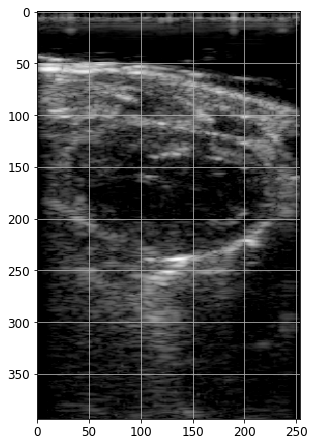

In [21]:
# display first slice
_ = plt.imshow(imInput[:, :, 0])

In [ ]:
# show video using opencv
utils.cvShowVideo(utils.normalizeArray(imInput), 'Input Video', resizeAmount=1.0)

### Run phase estimation algorithm

In [24]:
# Parameters
algo_params = {
    
    'median_filter_size': 1,    
    
    'detrend_method': 'hp',    
    'hp_lamda': 200,  # needs to be tuned - controls smoothness trend/respiration signal
    
    'band_pass_bpm': [1.0, 840.0],
    
    'similarity_method': 'pca',
    
    'respiration_present': True,
    'resp_phase_cutoff': 0.2,  # used 
}

print algo_params

algo = uspgs.USPGS(**algo_params)
algo.set_input(imInput, framesPerSec)
algo.process() 

ts = algo.get_frame_similarity_signal()

ts_resp = algo.get_respiration_signal()
ts_cardiac = algo.get_cardiac_signal()

ts_instaphase_resp = algo.get_respiratory_phase()
ts_instaphase_cardiac = algo.get_cardiac_phase()

period = algo.get_cardiac_cycle_duration()

{'band_pass_bpm': [1.0, 840.0], 'respiration_present': True, 'similarity_method': 'pca', 'detrend_method': 'hp', 'resp_phase_cutoff': 0.2, 'hp_lamda': 200, 'median_filter_size': 1}
Input video size:  (394, 254, 796)

>> Step-1: Suppressing noise ...


Noise suppression took 15.60 seconds

>> Step-2: Estimating instantaneous phase ...

Reducing dimensionality using PCA ...  took 47.7029030323 seconds
641 eigen vectors used to cover 99.00% of variance

Computing similarity as -ve distance in pca space ... 
000 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 094 095 096 097 098 099 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 12

### Investigate phase estimation

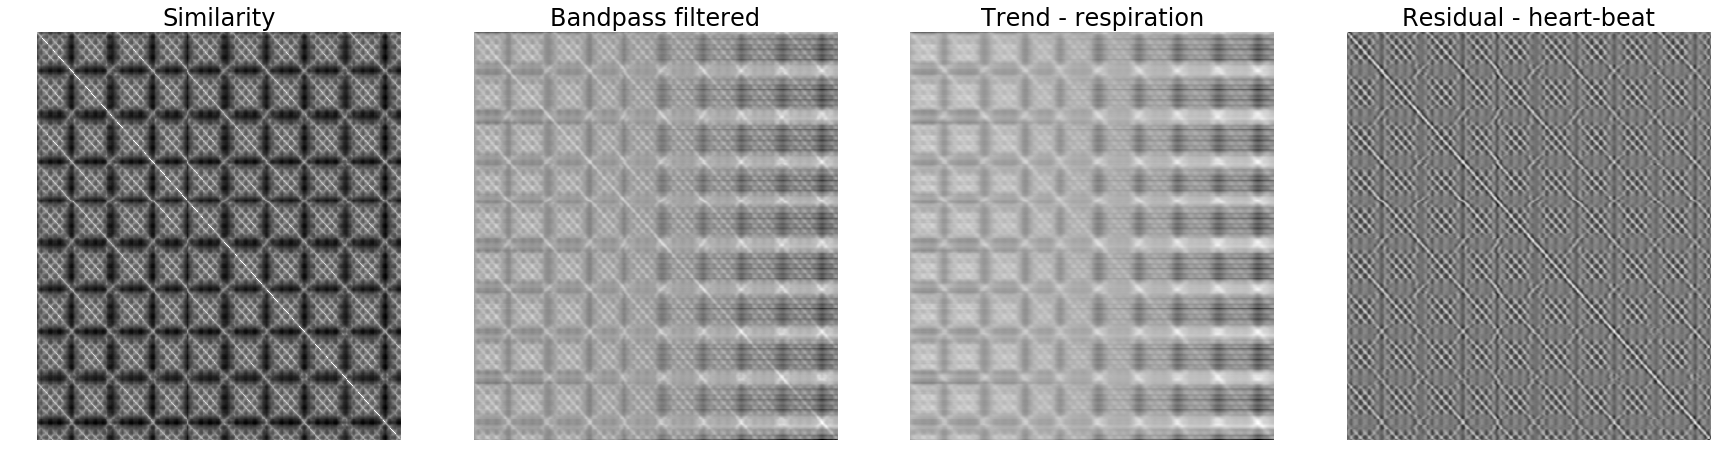

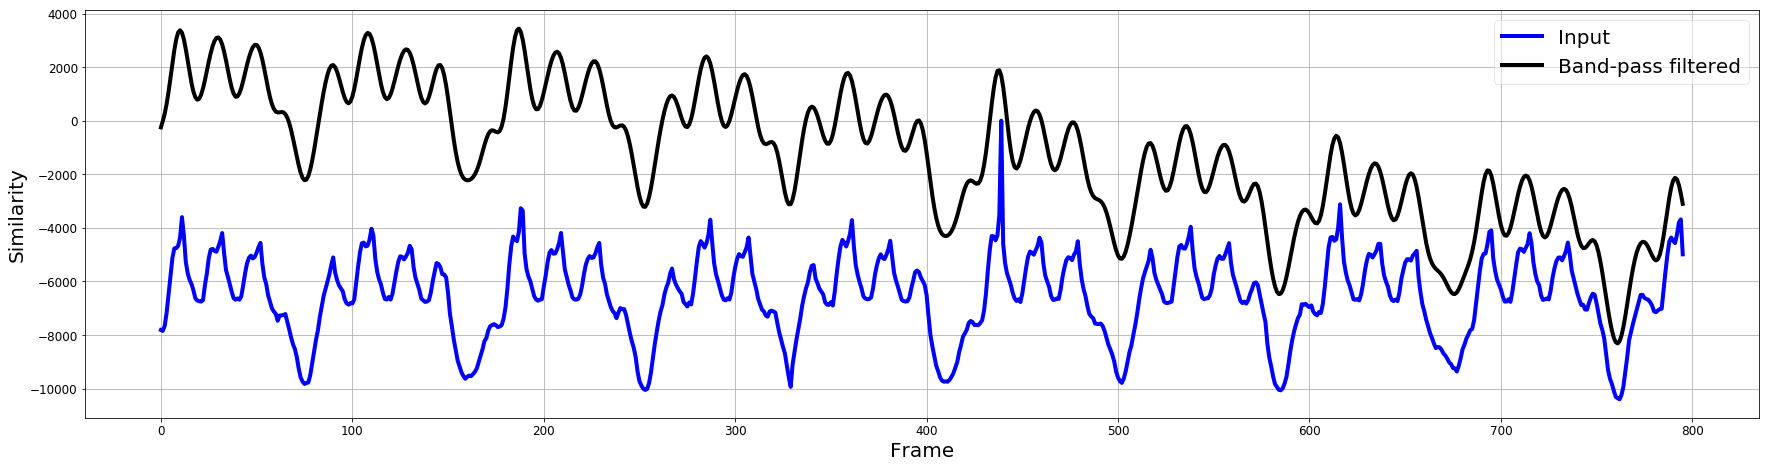

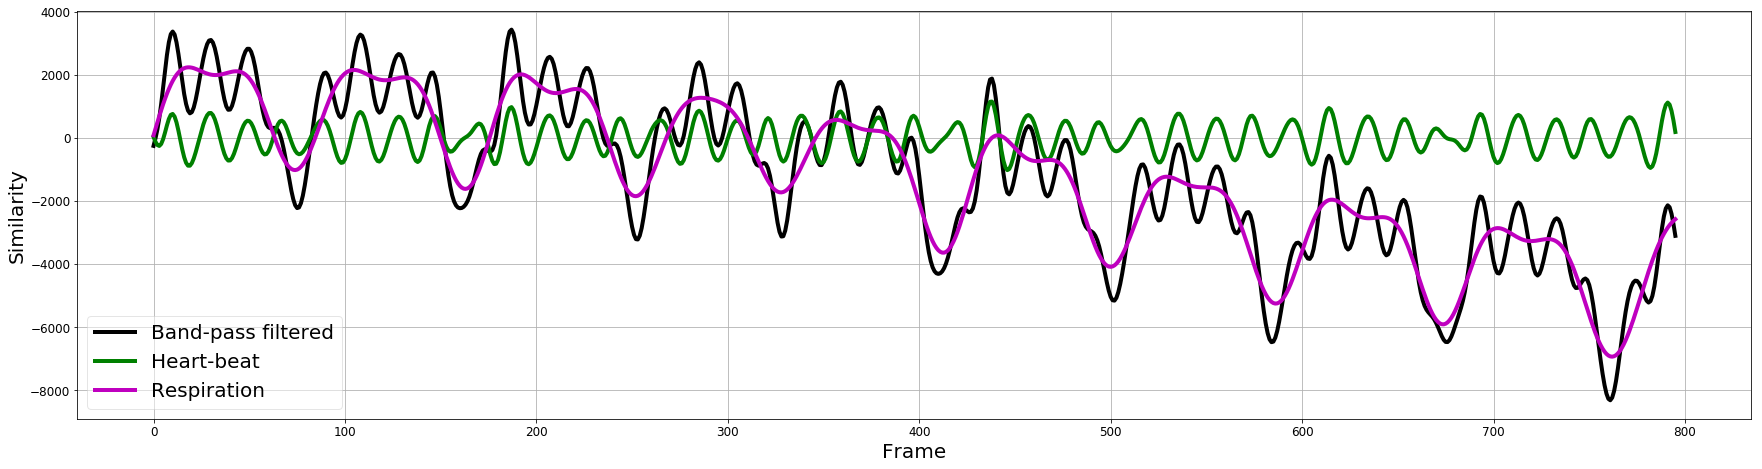

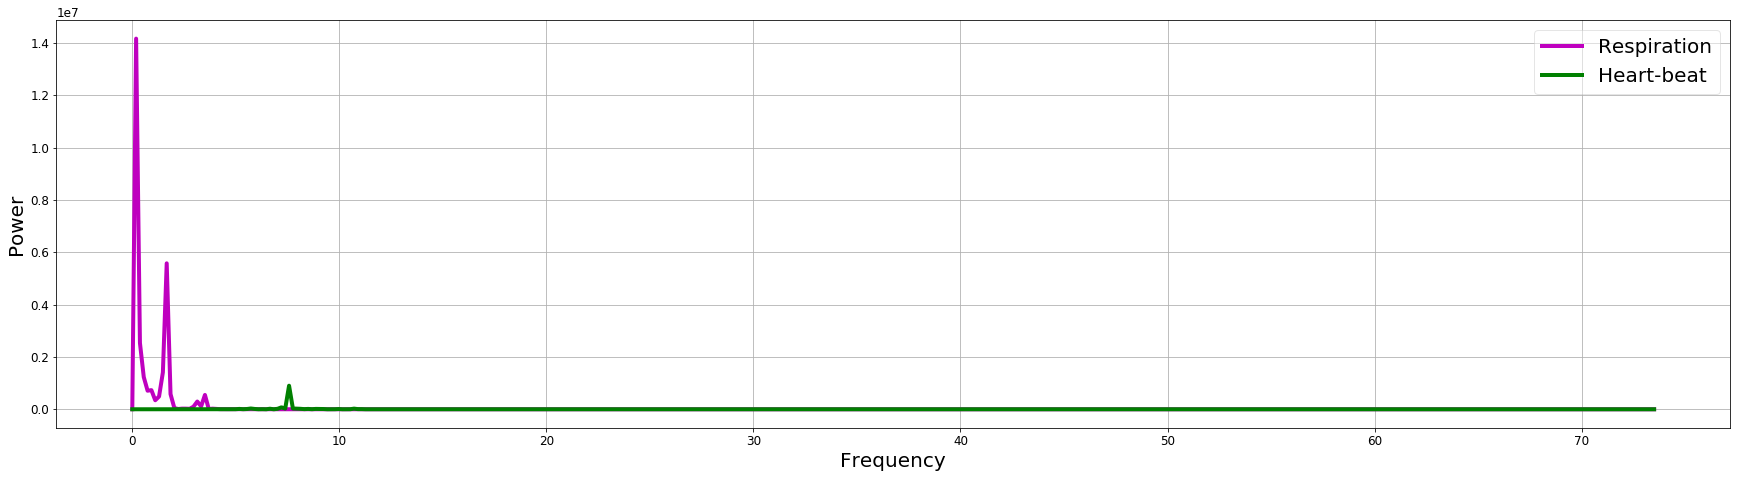

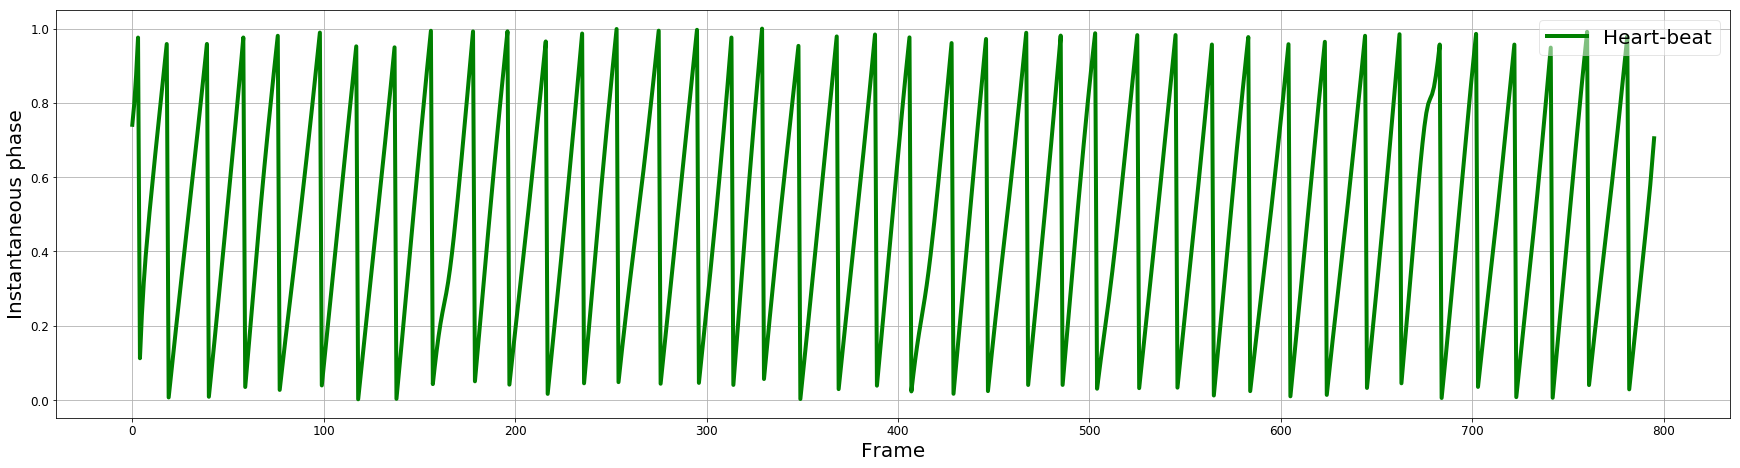

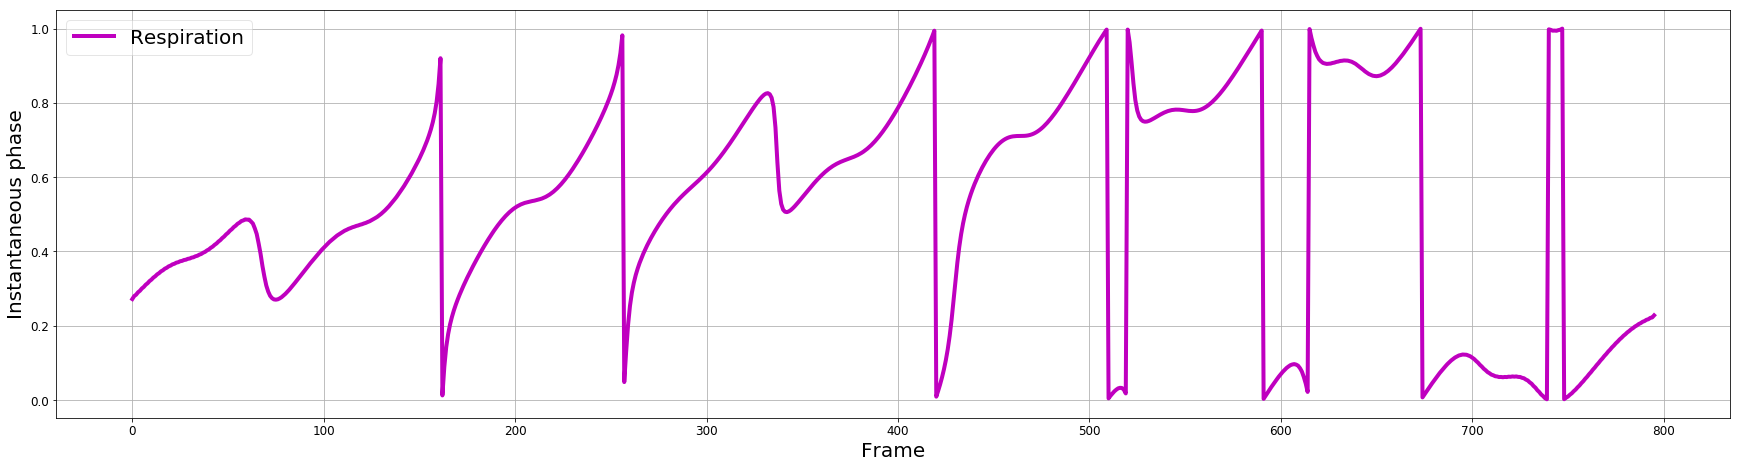

In [25]:
#
# plot the whole similarity landscape along with its trend and seasonal parts
#
fig, ax = plt.subplots(1, 4, sharey=True)

simMat = algo.simMat_
simMat_Bpass = algo.simMat_Bpass_
simMat_Trend = algo.simMat_Trend_
simMat_Seasonal = algo.simMat_Seasonal_

ax[0].imshow(simMat)
ax[0].set_title('Similarity')
ax[0].axis('off')
ax[0].axis('tight')

ax[1].imshow(simMat_Bpass)
ax[1].set_title('Bandpass filtered')
ax[1].axis('off')
ax[1].axis('tight')

ax[2].imshow(simMat_Trend)
ax[2].set_title('Trend - respiration')
ax[2].axis('off')
ax[2].axis('tight')

ax[3].imshow(simMat_Seasonal)
ax[3].set_title('Residual - heart-beat')
ax[3].axis('off')
ax[3].axis('tight')

# Show decoupling of respiration and cardiac signals
plt.figure()

plt.plot(ts, 'b-', label='Input')
plt.plot(algo.ts_bpass_, 'k-', label='Band-pass filtered')
plt.xlabel('Frame')
plt.ylabel('Similarity')
plt.legend(framealpha=0.5)

plt.figure()

plt.plot(algo.ts_bpass_, 'k-', label='Band-pass filtered')
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'm-', label='Respiration')
plt.xlabel('Frame')
plt.ylabel('Similarity')
plt.legend(framealpha=0.5)

# show frequency spectrum of trend/respiration and residual/cardiac components
freq_resp, power_resp = scipy.signal.periodogram(ts_resp, fs=framesPerSec)
freq_cardiac, power_cardiac = scipy.signal.periodogram(ts_cardiac, fs=framesPerSec)

plt.figure()
plt.plot(freq_resp, power_resp, 'm-', label='Respiration')
plt.plot(freq_cardiac, power_cardiac, 'g-', label='Heart-beat')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(framealpha=0.5)

# show estimate instantaneous phase of heart-beat and respiration
plt.figure()
plt.plot(ts_instaphase_cardiac, 'g-', label='Heart-beat')
plt.xlabel('Frame')
plt.ylabel('Instantaneous phase')
plt.legend(framealpha=0.5)

plt.figure()
plt.plot(ts_instaphase_resp, 'm-', label='Respiration')
plt.xlabel('Frame')
plt.ylabel('Instantaneous phase')
plt.legend(framealpha=0.5)

### Investigate respiratory gating

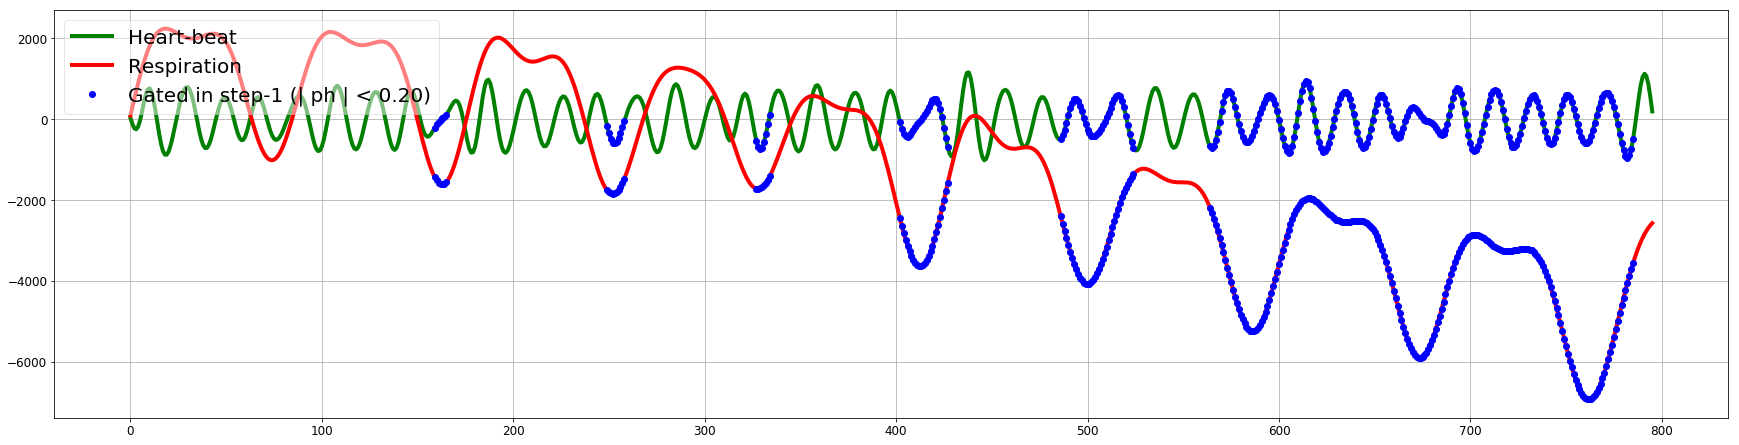

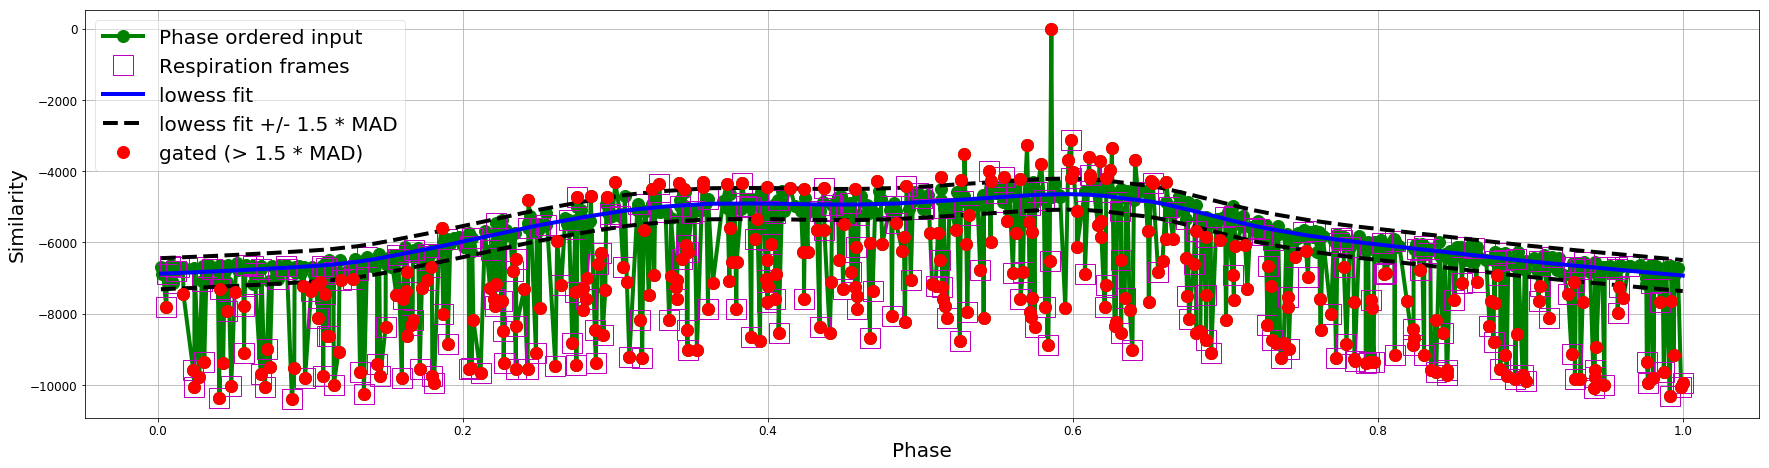

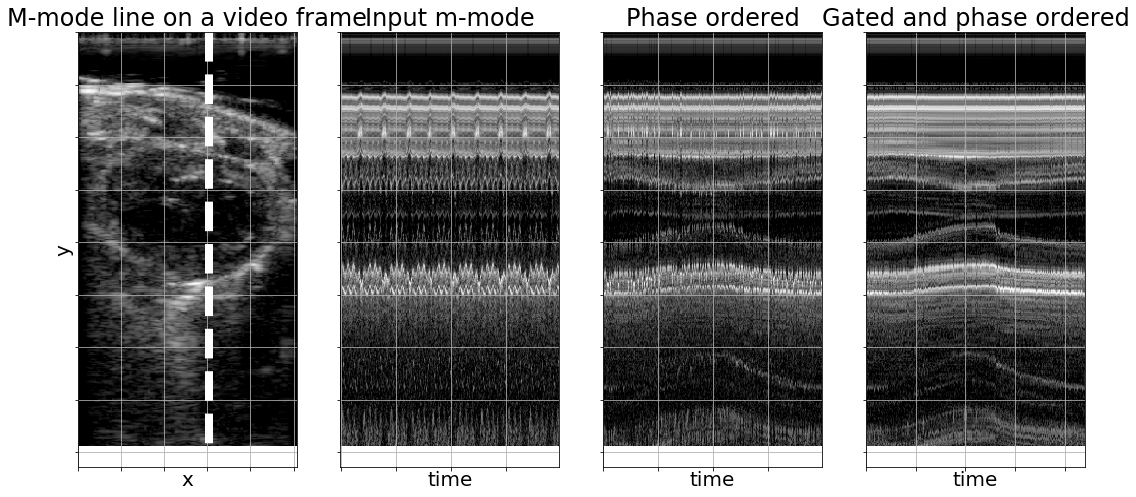

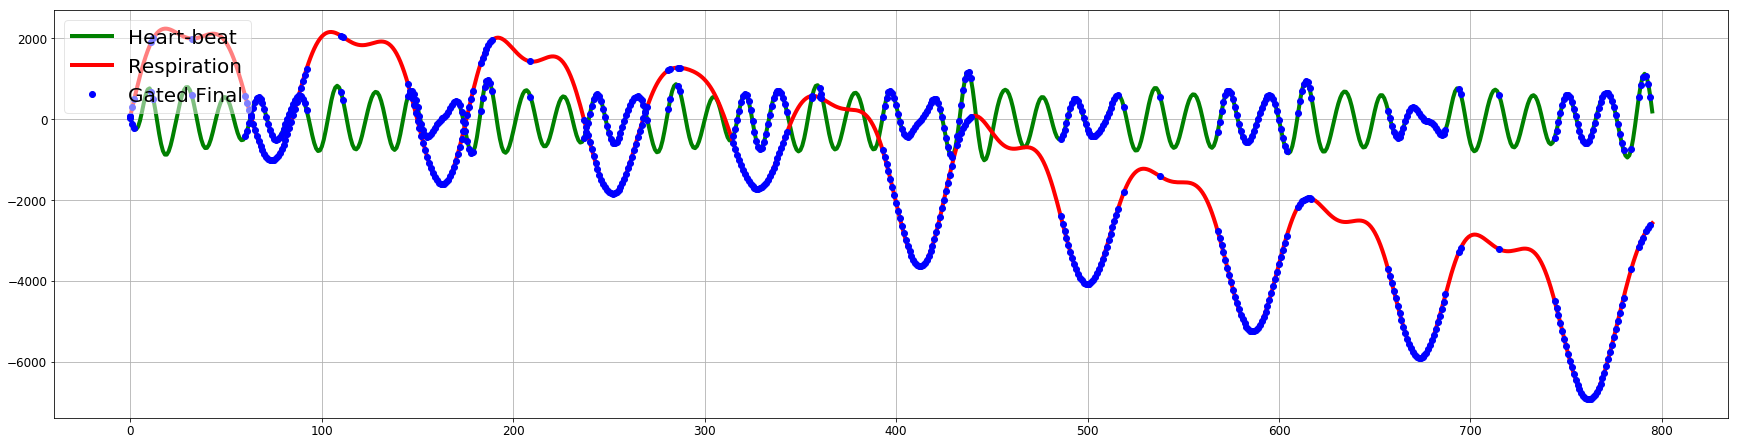

In [26]:
mmode_pos = int(0.6 * imInput.shape[1])
image_aspect = np.float(imInput.shape[1]) / imInput.shape[0]

# order m-mode frames by estimated cardiac phase before and after gating
phaseord_est = np.argsort(ts_instaphase_cardiac)
imInput_phaseord = imInput[:,:,phaseord_est]

k_mad = 1.5
resp_ind = algo.resp_ind_
fid_lowess = algo.fid_lowess_
sim_lowess_reg = algo.sim_lowess_reg_

ph_resp = ts_instaphase_cardiac[resp_ind]
sim_resp = simMat[fid_lowess, resp_ind]

ph_org = ts_instaphase_cardiac[phaseord_est]
sim_org = simMat[fid_lowess, phaseord_est]

sim_lowess = sim_lowess_reg.predict(ph_org)

gated_ind = phaseord_est[np.argwhere(abs(sim_org - sim_lowess) > k_mad * sim_lowess_reg.residual_mad())]
phaseord_est_gated = [fid for fid in phaseord_est if fid not in gated_ind]
imInput_phaseord_gated = imInput[: , :, phaseord_est_gated]

ph_gated = ts_instaphase_cardiac[gated_ind]
sim_gated = simMat[fid_lowess, gated_ind]

# visualize frames thrownout in the first step of respiratory gating
plt.figure()
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'r-', label='Respiration')
plt.plot(resp_ind, ts_cardiac[resp_ind], 'b.', label='Gated in step-1 (| ph | < %.2f)' % algo.resp_phase_cutoff)
plt.plot(resp_ind, ts_resp[resp_ind], 'b.')
plt.legend(framealpha=0.5, loc='upper left');

# visualize lowess fit and gated frames
plt.figure()

plt.plot(ph_org, sim_org, 'g-o', label='Phase ordered input')
plt.plot(ph_resp, sim_resp, 'ms', label='Respiration frames',
         fillstyle='none', markersize=20)
plt.plot(ph_org, sim_lowess, 'b-', label='lowess fit')

plt.plot(ph_org, sim_lowess + k_mad * sim_lowess_reg.residual_mad(), 'k--')
plt.plot(ph_org, sim_lowess - k_mad * sim_lowess_reg.residual_mad(), 'k--', label='lowess fit +/- %.1f * MAD' % k_mad)

plt.plot(ph_gated, sim_gated, 'ro', label='gated (> %.1f * MAD)' % k_mad)

plt.xlabel('Phase')
plt.ylabel('Similarity')
plt.legend(loc='upper left', framealpha=0.5)

# show m-mode frames ordered by estimated phase
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(8 * image_aspect * 3.5, 8))

ax[0].imshow(imInput[:, :, 0])
ax[0].plot([mmode_pos, mmode_pos], [0, imInput.shape[0]], 'w--', linewidth=8)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('M-mode line on a video frame')
# ax[0].axis('off')
ax[0].axis('tight')

ax[1].imshow(imInput[:, mmode_pos, :])
ax[1].set_xlabel('time')
ax[1].set_title('Input m-mode')
# ax[1].axis('off')
ax[1].axis('tight')

ax[2].imshow(imInput_phaseord[:, mmode_pos, :])
ax[2].set_xlabel('time')
ax[2].set_title('Phase ordered')
# ax[2].axis('off')
ax[2].axis('tight')

ax[3].imshow(imInput_phaseord_gated[:, mmode_pos, :])
ax[3].set_xlabel('time')
ax[3].set_title('Gated and phase ordered')
# ax[3].axis('off')
ax[3].axis('tight')

_ = plt.setp([a.get_xticklabels() for a in ax], visible=False)
_ = plt.setp([a.get_yticklabels() for a in ax], visible=False)

# show final gated frames
plt.figure()
plt.plot(ts_cardiac, 'g-', label='Heart-beat')
plt.plot(ts_resp, 'r-', label='Respiration')
plt.plot(gated_ind, ts_cardiac[gated_ind], 'b.', label='Gated Final')
plt.plot(gated_ind, ts_resp[gated_ind], 'b.')
plt.legend(framealpha=0.5, loc='upper left');

### Generate and visualize single cycle video at desired resolution

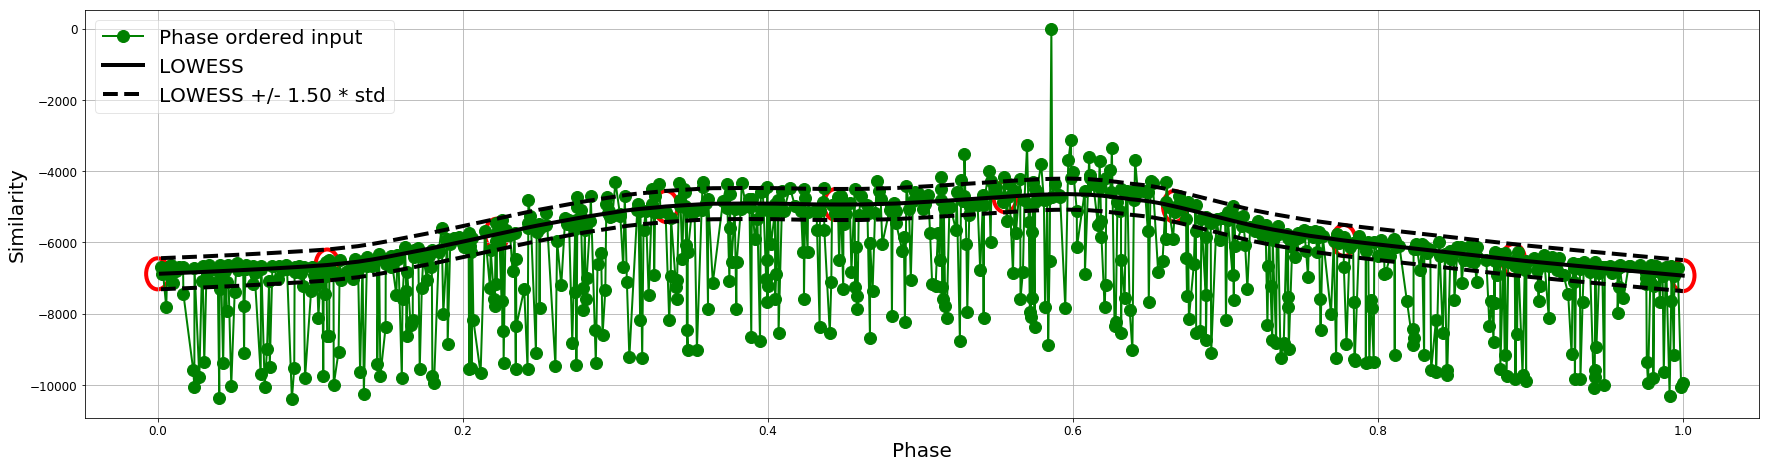

In [27]:
# tweak and visualize sigma factors for kernel regression
kPhase = 0.1
kSim = 1.5
mag = 1

synthPhaseVals = np.linspace(0, 1, 10)

phaseord_est = np.argsort(algo.ts_instaphase_nmzd_)

ph_org = algo.ts_instaphase_nmzd_[phaseord_est]
sim_org = algo.ts_[phaseord_est]

sim_lowess = algo.sim_lowess_reg_.predict(ph_org)
sim_mad = algo.sim_lowess_reg_.residual_mad()

pdiff = uspgs.phaseDiff(algo.ts_instaphase_nmzd_)
pstd = sm.robust.scale.mad(pdiff, center=0)

synthPhaseSims = algo.sim_lowess_reg_.predict(synthPhaseVals)

wPhase = 2 * kPhase * pstd
wSim = 2 * kSim * sim_mad

plt.plot(ph_org, sim_org, 'g-o', linewidth=linewidth/2, label='Phase ordered input')
plt.plot(ph_org, sim_lowess, 'k-', label='LOWESS')

plt.plot(ph_org, sim_lowess + kSim * sim_mad, 'k--')
plt.plot(ph_org, sim_lowess - kSim * sim_mad, 'k--', label='LOWESS +/- %.2f * std' % kSim)

for cur_ph, cur_sim in zip(synthPhaseVals, synthPhaseSims):
    
    c = [cur_ph, cur_sim]
    
    cur_el = mpatches.Ellipse(xy=c, width=wPhase, height=wSim, fill=False, color='r', linewidth=linewidth)
    plt.gca().add_patch(cur_el)

plt.xlabel('Phase')
plt.ylabel('Similarity')
plt.legend(loc='upper left', framealpha=0.5)

In [28]:
# set parmeters
upsampleAmount = 8
sigmaPhaseFactor = kPhase
sigmaSimilarityFactor = kSim

mparams = uspgs.config_framegen_using_kernel_regression(
    sigmaPhaseFactor=sigmaPhaseFactor, 
    sigmaSimilarityFactor=sigmaSimilarityFactor, 
    stochastic=False
)

numOutFrames = np.rint(upsampleAmount * period)        

imOnePeriodVideo = algo.generate_single_cycle_video(numOutFrames, imInput=imInput, method=mparams)

print imOnePeriodVideo.shape

01% 02% 03% 04% 05% 06% 07% 08% 09% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 

(394, 254, 155)


In [32]:
# show video using opencv
utils.cvShowVideo(utils.normalizeArray(imOnePeriodVideo), 'Input Video Upsampled', resizeAmount=1.0)

#### Visually check images at and between cardiac phase minima where cycle begin/end

Text(0.5,0,u'Frame')

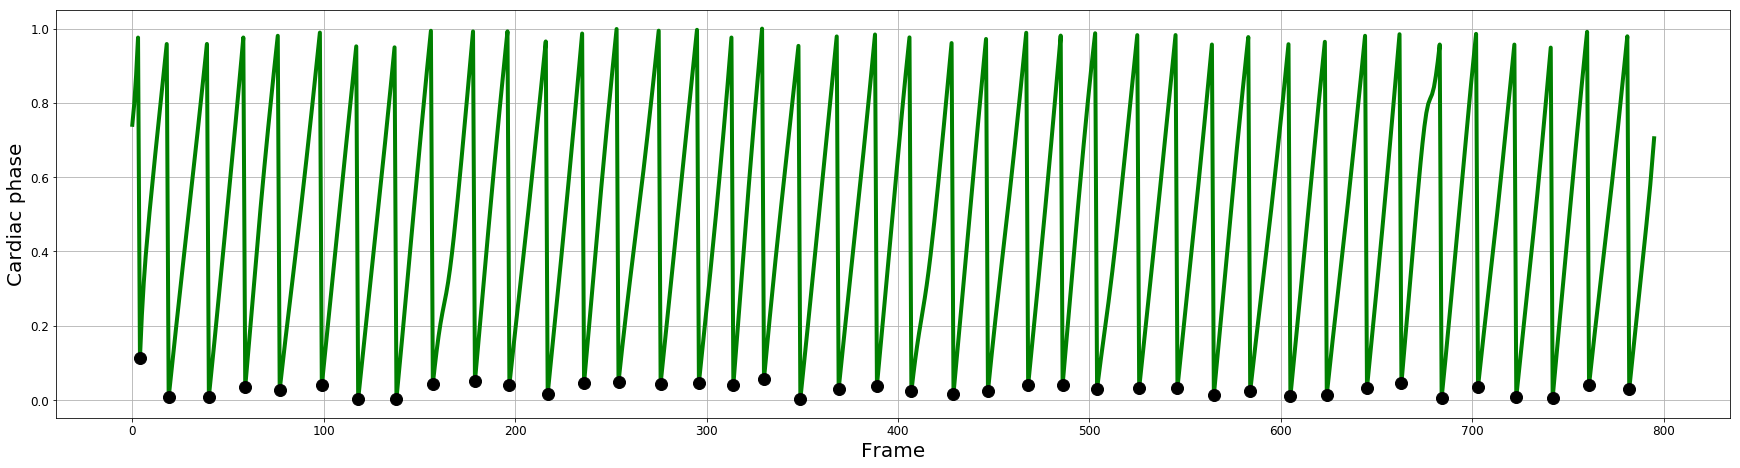

In [29]:
# detect cardiac phase valley points
ts_instaphase_cardiac_vloc = detect_peaks(ts_instaphase_cardiac, mpd=algo.period_ * 0.65, valley=True, show=False)

plt.plot(ts_instaphase_cardiac, 'g-', label='Cardiac phase')
plt.plot(ts_instaphase_cardiac_vloc, ts_instaphase_cardiac[ts_instaphase_cardiac_vloc], 'ko', 
         label='Cardiac phase minima')

plt.ylabel('Cardiac phase')
plt.xlabel('Frame')

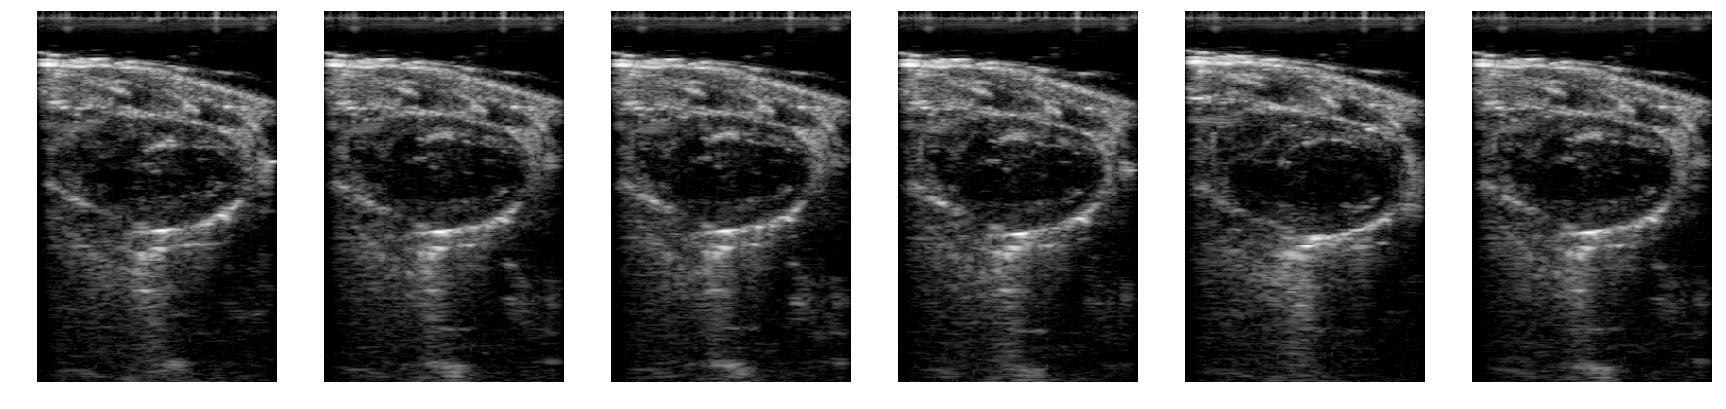

In [30]:
# visualize and verify if frames at cardiac phase minima look similar
num_minima_to_disp = 6

for i in range(num_minima_to_disp):
    
    plt.subplot(1, num_minima_to_disp, i+1)
    plt.imshow(imInput[:, :, ts_instaphase_cardiac_vloc[i]])
    plt.axis('off')    

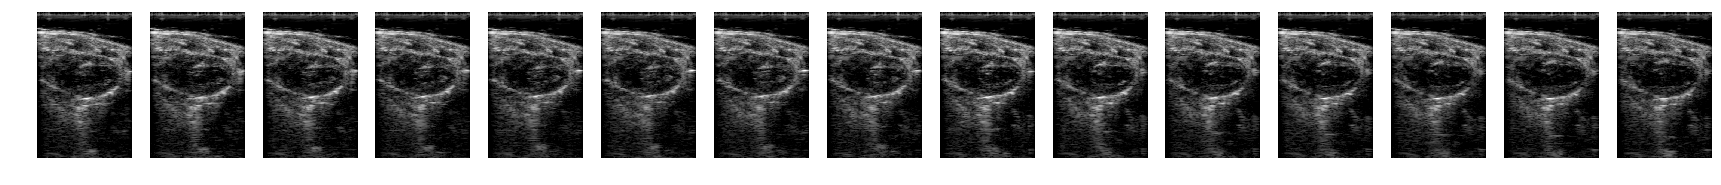

In [31]:
# visualize frames between two cardiac phase minima
pid = 0

f_insta = range(ts_instaphase_cardiac_vloc[pid], ts_instaphase_cardiac_vloc[pid+1])

for i in range(len(f_insta)):
    
    plt.subplot(1, len(f_insta), i+1)
    plt.imshow(imInput[:, :, f_insta[i]])
    plt.axis('off')    